In [1]:
import datetime
current_datetime = datetime.datetime.today()
print("This .ipynb last executed at {0}".format(current_datetime))

This .ipynb last executed at 2020-05-12 10:28:18.288807


# Train the CNN model

## Steps
1. Import the prepared train set and test set RSSI data from "5.1 DNN CNN Data Preparation".
2. Reshape the multi-dimensional tabular data so that it is accepted by Keras
3. Create Convolutional Neural Network Model in Keras
4. Train the deep neural network for human activity recognition data
5. Validate the performance of the trained DNN against the test data using learning curve and confusion matrix
6. Save and Export the trained DNN model in .h5 format

## Import Libraries
Import all necessary python libraries.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) #Setting to display All columns of Dataframe
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils


Using TensorFlow backend.


## Function - Load Testing Data

In [3]:

#Prepare data for prediction
def prepareMLData(dataframe=None):
    drop_col_name = ['device','seqNumber','location','LocationEncoded','gps','file',
                     'PathLossExponent','ReferenceRSSI','DeviceLLSLat','DeviceLLSLng','LocalizationError',
                     'nCrPathLossExponent','nCrReferenceRSSI','nCrDeviceLLSLat','nCrDeviceLLSLng','nCrLocalizationError'
                    ]
    x_data = dataframe.drop(drop_col_name,axis=1)
    y_data = dataframe['LocationEncoded']
    print('x_data shape:', x_data.shape,'(#data, #dimension)')
    
    #Before continuing, we need to convert all feature data (x_test) and 
    #label data (y_test) into a datatype accepted by Keras.
    x_data = x_data.astype('float32')
    y_data = y_data.astype('float32')
    #Conduct one-hot-encoding of our labels. Please only execute this line once!
    num_classes = len(y_data.unique().tolist())
    y_data_hot = np_utils.to_categorical(y_data, num_classes)
    return x_data,y_data,y_data_hot

In [4]:
#Get rssi data
normalized_train_data_filepath = '5.1_normalized_train_data.xlsx'
normalized_test_data_filepath = '5.1_normalized_test_data.xlsx'
augmented_train_data_filepath = '5.1_normalized_train_augmented_data.csv'
print("Importing......")
##Import train data for reference
df_normalized_train = pd.read_excel(normalized_train_data_filepath, index_col=0)
print(normalized_train_data_filepath)
##Import augmentation train rssi data
df_augmented_normalized_train = pd.read_csv(augmented_train_data_filepath, index_col=0)
print(augmented_train_data_filepath)
##Import test data to make DNN to predict
df_normalized_test = pd.read_excel(normalized_test_data_filepath, index_col=0)
print(normalized_test_data_filepath)
print()

#Prepare data for training
x_train, y_train, y_train_hot = prepareMLData(df_normalized_train)
x_train_augment, y_train_augment, y_train_augment_hot = prepareMLData(df_augmented_normalized_train)
x_test, y_test, y_test_hot = prepareMLData(df_normalized_test)


Importing......
5.1_normalized_train_data.xlsx
5.1_normalized_train_augmented_data.csv
5.1_normalized_test_data.xlsx

x_data shape: (1246, 71) (#data, #dimension)
x_data shape: (76006, 71) (#data, #dimension)
x_data shape: (90, 71) (#data, #dimension)


In [5]:
LABELS = df_normalized_train['location'].unique().tolist()
print(LABELS)
x_train_augment

['loc1', 'loc2', 'loc3', 'loc4']


,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155
0,0.000000,0.0,0.0,0.0,0.185714,0.528571,0.771429,0.285714,0.328571,0.514286,0.542857,0.300000,0.0,0.000000,0.314286,0.0,0.0,0.000000,0.800000,0.314286,0.0,0.600000,0.0,0.657143,0.0,0.0,0.0,0.0,0.357143,0.300000,0.871429,0.0,0.0,0.328571,0.0,0.0,0.0,0.371429,0.000000,0.0,0.000000,0.400000,0.0,0.0,0.271429,0.485714,0.528571,0.671429,0.0,0.0,0.542857,0.585714,0.485714,0.0,0.0,0.542857,0.528571,0.0,0.385714,0.357143,0.557143,0.0,0.0,0.000000,0.000000,0.0,0.0,0.457143,0.228571,0.157143,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.542857,0.842857,0.271429,0.000000,0.000000,0.600000,0.328571,0.0,0.000000,0.171429,0.0,0.0,0.000000,0.757143,0.328571,0.0,0.500000,0.0,0.671429,0.0,0.0,0.0,0.0,0.371429,0.000000,0.857143,0.0,0.0,0.300000,0.0,0.0,0.0,0.257143,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.300000,0.442857,0.528571,0.514286,0.0,0.0,0.628571,0.542857,0.457143,0.0,0.0,0.485714,0.485714,0.0,0.000000,0.000000,0.585714,0.0,0.0,0.000000,0.000000,0.0,0.0,0.400000,0.114286,0.000000,0.0
2,0.185714,0.0,0.0,0.0,0.242857,0.557143,0.900000,0.271429,0.400000,0.571429,0.528571,0.371429,0.0,0.142857,0.328571,0.0,0.0,0.157143,0.728571,0.428571,0.0,0.500000,0.0,0.700000,0.0,0.0,0.0,0.0,0.385714,0.300000,0.857143,0.0,0.0,0.342857,0.0,0.0,0.0,0.400000,0.057143,0.0,0.128571,0.400000,0.0,0.0,0.285714,0.471429,0.571429,0.600000,0.0,0.0,0.642857,0.628571,0.428571,0.0,0.0,0.514286,0.414286,0.0,0.357143,0.357143,0.685714,0.0,0.0,0.000000,0.000000,0.0,0.0,0.428571,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.528571,0.928571,0.285714,0.271429,0.471429,0.614286,0.357143,0.0,0.000000,0.100000,0.0,0.0,0.000000,0.714286,0.342857,0.0,0.500000,0.0,0.642857,0.0,0.0,0.0,0.0,0.400000,0.000000,0.842857,0.0,0.0,0.342857,0.0,0.0,0.0,0.300000,0.000000,0.0,0.000000,0.385714,0.0,0.0,0.314286,0.400000,0.571429,0.642857,0.0,0.0,0.600000,0.471429,0.485714,0.0,0.0,0.471429,0.471429,0.0,0.000000,0.000000,0.628571,0.0,0.0,0.000000,0.000000,0.0,0.0,0.400000,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.257143,0.600000,0.900000,0.314286,0.385714,0.528571,0.514286,0.371429,0.0,0.000000,0.285714,0.0,0.0,0.128571,0.714286,0.442857,0.0,0.542857,0.0,0.771429,0.0,0.0,0.0,0.0,0.428571,0.357143,0.857143,0.0,0.0,0.357143,0.0,0.0,0.0,0.357143,0.000000,0.0,0.000000,0.314286,0.0,0.0,0.285714,0.500000,0.614286,0.614286,0.0,0.0,0.600000,0.500000,0.442857,0.0,0.0,0.514286,0.485714,0.0,0.357143,0.342857,0.671429,0.0,0.0,0.000000,0.000000,0.0,0.0,0.442857,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76001,0.000000,0.0,0.0,0.0,0.157143,0.700000,0.485714,0.300000,0.242857,0.485714,0.600000,0.300000,0.0,0.000000,0.285714,0.0,0.0,0.000000,0.771429,0.357143,0.0,0.514286,0.0,0.728571,0.0,0.0,0.0,0.0,0.414286,0.300000,0.928571,0.0,0.0,0.142857,0.0,0.0,0.0,0.371429,0.000000,0.0,0.000000,0.414286,0.0,0.0,0.385714,0.542857,0.600000,0.542857,0.0,0.0,0.400000,0.628571,0.357143,0.0,0.0,0.600000,0.514286,0.0,0.428571,0.257143,0.714286,0.0,0.2,0.142857,0.085714,0.0,0.0,0.342857,0.300000,0.000000,0.0
76002,0.000000,0.0,0.0,0.0,0.200000,0.700000,0.485714,0.257143,0.242857,0.485714,0.500000,0.300000,0.0,0.000000,0.285714,0.0,0.0,0.000000,0.771429,0.357143,0.0,0.528571,0.0,0.728571,0.0,0.0,0.0,0.0,0.414286,0.328571,0.928571,0.0,0.0,0.157143,0.0,0.0,0.0,0.371429,0.000000,0.0,0.000000,0.414286,0.0,0.0,0.400000,0.571429,0.600000,0.528571,0.0,0.0,0.371429,0.628571,0.357143,0.0,0.0,0.600000,0.514286,0.0,0.4

## 3 Create Neural Network (CNN) Model in Keras

In [6]:

def reshapeDataToCNN(dataframe):
    """ Change the shape of the dataset,
    so that the shape of the data can be accepted by cnn"""
    df = dataframe.copy()
    df.insert(loc=len(df.columns),column="EXTRA", value=0.0)
    l1=[]
    l2=[]
    l3=[]
    for a,b in dataframe.iterrows():
        l1.append(b.tolist())

    for a in l1:
        for b in a:
            l2.append([b])
        l3.append(l2)
        l2 = []
    return np.array(l3)


In [7]:

copy_x_train_augment = reshapeDataToCNN(x_train_augment)
copy_x_train = reshapeDataToCNN(x_train)
copy_x_test = reshapeDataToCNN(x_test)

print(copy_x_train_augment.shape)
print(copy_x_train.shape)
print(copy_x_test.shape)

n_timesteps = copy_x_train_augment.shape[1]
n_features = copy_x_train_augment.shape[2]
n_outputs = y_train_augment_hot.shape[1]
print(n_timesteps)
print(n_features)
print(n_outputs)

print(copy_x_train_augment.shape)
print(y_train_augment.shape)


(76006, 71, 1)
(1246, 71, 1)
(90, 71, 1)
71
1
4
(76006, 71, 1)
(76006,)


In [8]:
def train_cnn_1d(x_train, y_train, y_train_ohe, n_filter=64 ,n_conv_layer=[10], n_fully_connected=[128],
                 optimizer='adam', act='relu', n_epochs=10, bat_size=50, verbose=0, n_repeat=None):

    # 1D CNN neural network
    model = Sequential()
    ##Input & hidden layers
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train_ohe.shape[1]
    model.add(Conv1D(filters=n_filter, kernel_size=n_conv_layer[0], activation='relu', 
                     input_shape=(n_timesteps,n_features)))
    #     model.add(BatchNormalization())
    #     model.add(MaxPooling1D(pool_size=2))
    #     model.add(Dropout(0.25))
    for kernel_size in n_conv_layer:
        print(kernel_size)
        model.add(Conv1D(filters=n_filter, kernel_size=kernel_size, activation='relu'))
    #     model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.25))
    ## Classification layer
    model.add(Flatten())
    ### Fully connected layer
    for n_nodes in n_fully_connected:
        model.add(Dense(n_nodes, activation='relu'))  
    ### Output layer
    model.add(Dropout(0.25))
    model.add(Dense(n_outputs, activation='softmax'))
    print(model.summary())

    # Define loss function and optimizer
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Perform training
    history = model.fit(x_train, y_train_ohe, epochs=n_epochs, batch_size=bat_size,verbose=verbose,
              validation_split=0.2)
    
    date = str(current_datetime.strftime("%Y%m%d"))
    time = str(current_datetime.strftime("%Hh%Mmin%S"))
    print(date,time)
    filepath = 'models/rssi_cnn_1d_{n_conv_layer}convlayer_{filter_size}filtersize_v{ver} aug.h5'.format(
        n_conv_layer=len(n_conv_layer), filter_size=n_conv_layer[0], ver=n_repeat
    )
    model.save(filepath)
    print(filepath)
    
    show_accuracy_loss_curve(history,model,bat_size,n_epochs,x_train, y_train, y_train_ohe)
    
    return model


In [9]:
def show_accuracy_loss_curve(history,model,bat_size,n_epochs,x_train,y_train,y_train_ohe):
    # Visualize the accuracy curve
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
#     plt.plot(history.history['loss'], 'r--', label='Loss of training data')
#     plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    # Visualize the loss curve
    plt.figure(figsize=(12, 5))
#     plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
#     plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    
    # Print confusion matrix for training data
    y_pred_train = model.predict(x_train)
    # Take the class with the highest probability from the train predictions
    max_y_pred_train = np.argmax(y_pred_train, axis=1)
    print(classification_report(y_train, max_y_pred_train))
    print('batch size:',bat_size)
    print('epochs:',n_epochs)


This .ipynb last executed at 2020-05-12 10:28:55.171322
10
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 62, 32)            352       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 53, 32)            10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 26, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 832)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               106624    
_____________________________________________________________

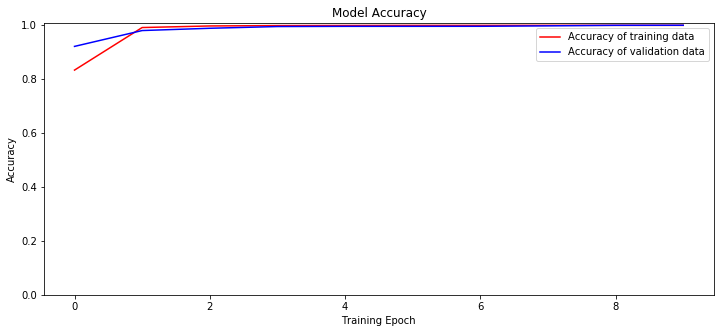

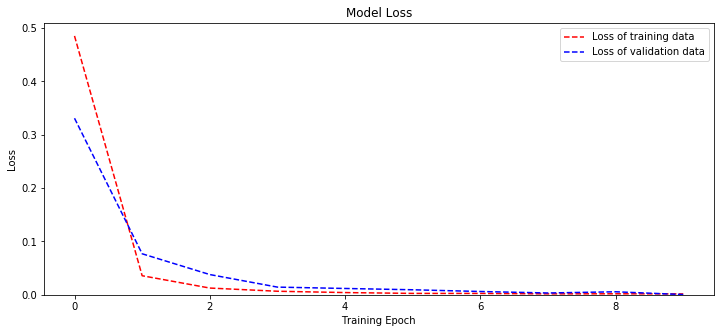

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19764
         1.0       1.00      1.00      1.00     19642
         2.0       1.00      1.00      1.00     18300
         3.0       1.00      1.00      1.00     18300

    accuracy                           1.00     76006
   macro avg       1.00      1.00      1.00     76006
weighted avg       1.00      1.00      1.00     76006

batch size: 500
epochs: 10
###################### END (Count:0) ##################################################################

This .ipynb last executed at 2020-05-12 10:33:51.949698


In [10]:

# Train a CNN
repeats = 1
batch_size = 500
epochs = 10
n_filter = 32
filter_size = 10
n_conv_block = 1
conv_block = [filter_size]*n_conv_block
n_fully_connected = [128]

current_datetime = datetime.datetime.today()
print("This .ipynb last executed at {0}".format(current_datetime))

nn_list = list()
for i in range(repeats):
#     nn = train_dnn(x_train_augment, y_train_augment, y_train_augment_hot, n_hiddens=n_hiddens,
#                    optimizer='adam', act='relu', n_epochs=epochs, bat_size=batch_size, verbose=1)
    nn = train_cnn_1d(copy_x_train_augment, y_train_augment, y_train_augment_hot, 
                      n_filter=n_filter,
                      n_conv_layer=conv_block, n_fully_connected=n_fully_connected,
                      optimizer='adam', act='relu', n_epochs=epochs, bat_size=batch_size, verbose=0,
                      n_repeat=i
                     )
    nn_list.append(nn)
    
    print("###################### END (Count:{}) ##################################################################\n".format(i))

    current_datetime = datetime.datetime.today()
    print("This .ipynb last executed at {0}".format(current_datetime))
    

In [11]:

def test_nn(x_test, y_test, y_test_hot, model):
    """
    :param x_test: N x D ndarray of test data, where D is the feature dimension
    :param y_test: N x nClass ndarray of target labels
    :param model: DNN model created by train_dnn()
    :return: test accuracy, no. of correct, and no. of samples in x_test
    """
    y_pred = model.predict_classes(x_test, verbose=0)
    n_correct = np.sum(y_test == y_pred, axis=0)
    n_samples = x_test.shape[0]
    test_acc = n_correct / n_samples
    
#     socre = model.evaluate(x_test,y_test_hot, verbose=1)
    return test_acc, n_correct, n_samples#, socre


In [12]:
print('repeats =',repeats)
print('batch_size =',batch_size)
print('epochs =',epochs)
print('n_filter =',n_filter)
print('filter_size =',filter_size)
print('n_conv_block =',n_conv_block)
print('conv_block =',conv_block)
print('n_fully_connected =',n_fully_connected)
print('=====================================')

sum_test_acc = list()
for nn,i in zip(nn_list,range(len(nn_list))):
    i += 1
#     if i>=21:
#         break
    print('Count:',i,end=', ')
    # Test the NN
    train_acc, _, _ = test_nn(copy_x_train, y_train, y_train_hot, nn)
    test_acc, _, _ = test_nn(copy_x_test, y_test, y_test_hot, nn)
    sum_test_acc.append(test_acc)
    print('Train accuracy: %.3f%% ' % (train_acc * 100),end=", ")
    print('Test accuracy: %.3f%% ' % (test_acc * 100))
#     print('\nAccuracy on test data: %0.4f' % score[1])
#     print('\nLoss on test data: %0.4f' % score[0])
    

print()
print('avg:',sum(sum_test_acc) / len(sum_test_acc)*100)
print('max:',max(sum_test_acc)*100)
print('min:',min(sum_test_acc)*100)

repeats = 1
batch_size = 500
epochs = 10
n_filter = 32
filter_size = 10
n_conv_block = 1
conv_block = [10]
n_fully_connected = [128]
Count: 1, Train accuracy: 99.920% , Test accuracy: 74.444% 

avg: 74.44444444444444
max: 74.44444444444444
min: 74.44444444444444


## Save and Export the ML model

In [13]:
# def save_export_nn(nn,i,score):
#     # Save the model
#     date = str(current_datetime.strftime("%Y%m%d"))
#     time = str(current_datetime.strftime("%Hh%Mmin%S"))
#     print(date,time)
#     filepath = 'models/rssi_cnn_1d_{n_conv_layer}convlayer_{filter_size}filtersize_v{ver}.h5'.format(
#         n_conv_layer=len(n_conv_layer), filter_size=n_conv_layer[0], ver=i
#     )
#     nn.save(filepath)
#     print(filepath)
#     pass
# for nn,i in zip(nn_list,range(len(nn_list))):
#     i += 1
#     print(i)
#     score = nn.evaluate(copy_x_test,y_test_hot, verbose=1)
#     save_export_nn(nn,i,score)
# # # Recreate the exact same model purely from the file
# # new_model = keras.models.load_model('models/path_to_my_model.h5')

## Show confusion matrix

In [14]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(matrix,
                     cmap = "RdBu",
                     linecolor='white',
                     linewidths=1,
                     annot=True,
                     fmt='d',
                     xticklabels=LABELS,
                     yticklabels=LABELS
                    )
    bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    

--- Extra -----------------
batch size: 500
epochs: 10
[[23  1  0  0]
 [ 0 17  0  5]
 [ 0  0  5 17]
 [ 0  0  0 22]]


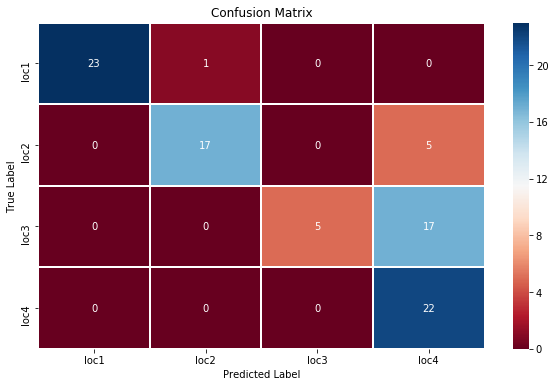

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.94      0.77      0.85        22
           2       1.00      0.23      0.37        22
           3       0.50      1.00      0.67        22

    accuracy                           0.74        90
   macro avg       0.86      0.74      0.72        90
weighted avg       0.86      0.74      0.72        90



In [15]:

# Print the BATCH_SIZE, EPOCHS
print('--- Extra -----------------')
print('batch size:',batch_size)
print('epochs:',epochs)

for nn,i in zip(nn_list,range(len(nn_list))):
    y_pred_test = nn.predict(copy_x_test)
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test_hot, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test)

    print(classification_report(max_y_test, max_y_pred_test))

